<a href="https://www.kaggle.com/code/christopherbabytitan/shadows-of-a-pandemic?scriptVersionId=190066261" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Shadows of a Pandemic
<hr>

### Table of Contents
1. [**Overview**](#overview)
2. [**Setup**](#sec1)
    * [Import libraries](#sub1)
    * [Open files](#sub2)
3. [**Cleaning**](#sec2)
    * [Cleaning](#sub3)
    * [Drop unecessary information](#sub4)
    * [Preform NLP](#sub5)
4. [**Vectorize Terms**](#sec3)
    * [Load vectors](#sub6)
    * [Change all words to vectors](#sub7)
5. [**Dimensionality Reduction**](#sec4)
    * [Create heatmaps](#sub8)
6. [**Train the model**](#sec5)
    * [Split testing and validation dataset](#sub9)
    * [Define model](#sub10)
    * [Train](#sub11)
7. [**Evaluate**](#sec6)
    * [Load vectors](#sub12)
    * [Testing](#sub13)
    * [Plot Confusion Matrix](#sub14)

## Overview <a class="anchor"  id="overview"></a>
In 2020, at least 3 million people died of COVID-19 (WHO). How might this astronomical figure have been prevented? If we had known that the pandemic was approaching, maybe governments could have put more measures in place and the spread of this virus would have been less severe. This project, “Shadows of a Pandemic,” aims to do just that, using the novel approach of training an image recognition model on plots of word representations. By predicting pandemics, it will enable us to be more prepared for the next pandemic, and perhaps even avoid it completely. 


How might we do so? Well, we can plot out the Eigenvalues of [Google Search Terms](https://console.cloud.google.com/marketplace/product/bigquery-public-datasets/google-search-trends) using PCA, generate heat maps from them, and run image classification on them! Let's get straight into it.

## Setup <a class="anchor"  id="sec1"></a>
### Import Libraries <a class="anchor"  id="sub1"></a>

In [1]:
# Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import time
import tensorflow as tf
import pathlib
import seaborn as sn

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from gensim.models import KeyedVectors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

2024-07-27 22:24:31.934745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 22:24:31.934852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 22:24:32.060650: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Open files <a class="anchor"  id="sub2"></a>
The start of all our processes is data, as it is not possible to train an AI without data. I use data extracted from [Google BigQuery’s “Google Trends Top 25 Terms”](https://console.cloud.google.com/marketplace/product/bigquery-public-datasets/google-search-trends) which contains 4 databases, one with international top terms, one with international top rising terms, one with the top terms in the United States, and one with the top rising terms in the United States. Of these, our data was extracted from the international top terms database. It was selected from various dates and grouped into several CSV(Comma Separated Values) files; with the rows of weeks that I deemed fall under no pandemic, I inserted the rows into a file called no-pandemic. I also did the same for pre-pandemic, as well as peak-pandemic. We open them as DataFrames here:

In [2]:
# Open files
no_pandemic = pd.read_csv("/kaggle/input/pandemic/pandemic_data/no-pandemic.csv")
pre_pandemic = pd.read_csv("/kaggle/input/pandemic/pandemic_data/pre-pandemic.csv")
peak_pandemic = pd.read_csv("/kaggle/input/pandemic/pandemic_data/peak-pandemic.csv")

This is what they look like:

In [3]:
no_pandemic

,term,week,rank,country_name,region_name,region_code,country_code,score,refresh_date
0,BWF India Open 2024,2019-01-20,4.0,Malaysia,Malacca,MY-04,MY,NaN,2024-01-17
1,BWF India Open 2024,2019-01-20,4.0,Malaysia,Negeri Sembilan,MY-05,MY,NaN,2024-01-17
2,BWF India Open 2024,2019-01-20,4.0,Malaysia,Perak,MY-08,MY,NaN,2024-01-17
3,BWF India Open 2024,2019-01-20,4.0,Malaysia,Perlis,MY-09,MY,NaN,2024-01-17
4,BWF India Open 2024,2019-01-20,4.0,Malaysia,Sarawak,MY-13,MY,NaN,2024-01-17
...,...,...,...,...,...,...,...,...,...
4309051,Kansas City,2019-03-03,3.0,Finland,Southern Ostrobothnia,FI-03,FI,NaN,2024-02-16
4309052,ปรับโครงสร้างหนี้กยศ,2019-03-03,3.0,Thailand,Chanthaburi,TH-22,TH,NaN,2024-01-31
4309053,北鯖江駅 火災,2019-03-03,3.0,Japan,Miyagi Prefecture,JP-04,JP,NaN,2024-02-13
4309054,Wolves Manchester United,2019-03-03,3.0,Chile,Coquimbo Region,CL-CO,CL,NaN,2024-02-02


## Cleaning <a class="anchor"  id="sec2"></a>
Cleaning is necessitated to make vectorization work properly. Because Word2Vec (the word embedder we use) can only take in english words from A to Z, it is necessary that we clean the data to rid words that have letters otherwise.

But first...
### Drop unnecessary information <a class="anchor"  id="sub3"></a>
We need to change the data into a format that we can work with. Here we change the data so that each row is a week corresponding to a list of terms. It is then saved in a new Pandas DataFrame.

In [4]:
# Change into format Week: [Term1, Term2, Term3, ...]

# no_pandemic
no_pandemic_terms_series = no_pandemic.groupby(['week'])['term'] .apply(list)
# Save data in no_pandemic_terms
no_pandemic_terms = pd.DataFrame({'week':no_pandemic_terms_series.index, 'term':no_pandemic_terms_series.values})

# pre_pandemic
pre_pandemic_terms_series = pre_pandemic.groupby(['week'])['term'] .apply(list)
# Save data in pre_pandemic_terms
pre_pandemic_terms = pd.DataFrame({'week':pre_pandemic_terms_series.index, 'term':pre_pandemic_terms_series.values})

# peak_pandemic
peak_pandemic_terms_series = peak_pandemic.groupby(['week'])['term'] .apply(list)
# Save data in peak_pandemic_terms
peak_pandemic_terms = pd.DataFrame({'week':peak_pandemic_terms_series.index, 'term':peak_pandemic_terms_series.values})

Take a look at the new dataset now:

In [5]:
# Now opening new DataFrame, no_pandemic_terms
no_pandemic_terms

,week,term
0,2019-01-20,"[BWF India Open 2024, BWF India Open 2024, BWF..."
1,2019-01-27,"[Frank Farian, Unni Askeland, Jürgen Klopp, Gr..."
2,2019-02-03,"[Indonesia vs Jepang, Cô đi mà lấy chồng tôi, ..."
3,2019-02-10,"[Unni Askeland, Adana Demirspor - Kasımpaşa, S..."
4,2019-02-17,"[Lazio Bayern Monaco, Madrid vs Girona, Tcas, ..."
5,2019-02-24,"[América Real Estelí, Martinovics Dorina, Roc..."
6,2019-03,[Indonesia vs Thailand]
7,2019-03-03,"[Irak vs Vietnam, Taylor Fritz, Dune, Unirea P..."
8,2019-03-17,"[Joel Embiid, Anyone But You, Anyone But You, ..."
9,2019-03-24,"[วาเลนไทน์, Ebba Busch, Flamengo, 立法院長, UMK 20..."


### Preform NLP <a class="anchor"  id="sub4"></a>
Now, we can filter out terms with non a-z characters so Word2Vec can take it as input.

In [6]:
# Preform NLP; filter out all terms with non a-z characters

# Filters out non a-z characters (except for numbers)
def isEnglish(s):
    try:
        # Only include ASCII characters
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

# Filters out numbers
def filter_non_alphabetical(lst):
    return [word for word in lst if (isEnglish(word)) and (word.isalpha())]

# Apply filters
no_pandemic_terms["term"] = no_pandemic_terms["term"].apply(filter_non_alphabetical)
pre_pandemic_terms["term"] = pre_pandemic_terms["term"].apply(filter_non_alphabetical)
peak_pandemic_terms["term"] = peak_pandemic_terms["term"].apply(filter_non_alphabetical)

Now it looks like this:

In [7]:
no_pandemic_terms

,week,term
0,2019-01-20,[]
1,2019-01-27,"[Liverpool, Alcaraz, Griselda, Gremio, Socrate..."
2,2019-02-03,"[Schladming, Boca, Nes, Benfica, AFCON, Flamen..."
3,2019-02-10,"[RaiPlay, Runeberg, CAN, Flamengo, Gremio, Gal..."
4,2019-02-17,"[Tcas, Schladming, Schladming, Drake, Alcaraz,..."
5,2019-02-24,"[Racing, Malarie, Flamengo, Boca, Galatasaray,..."
6,2019-03,[]
7,2019-03-03,"[Dune, Stillwater, HSV, Sabalenka, Schladming,..."
8,2019-03-17,"[Ferilli, Heby, DUNE, RADWIMPS, Liverpool, Heb..."
9,2019-03-24,"[Flamengo, WhatsApp, Tcas, BVB, WhatsApp, Tolu..."


### Split search terms into words <a class="anchor"  id="sub4"></a>
The Word2Vec model we use only takes in one word at a time, so we must split up each search term into several search terms.

In [8]:
# Seperate all search term words into one list

# Filter splits lists
def split_list(lst):
    return ' '.join(lst).split()

# Apply filter
no_pandemic_terms["term"] = no_pandemic_terms["term"].apply(split_list)
pre_pandemic_terms["term"] = pre_pandemic_terms["term"].apply(split_list)
peak_pandemic_terms["term"] = peak_pandemic_terms["term"].apply(split_list)

And now it looks like this:

In [9]:
no_pandemic_terms

,week,term
0,2019-01-20,[]
1,2019-01-27,"[Liverpool, Alcaraz, Griselda, Gremio, Socrate..."
2,2019-02-03,"[Schladming, Boca, Nes, Benfica, AFCON, Flamen..."
3,2019-02-10,"[RaiPlay, Runeberg, CAN, Flamengo, Gremio, Gal..."
4,2019-02-17,"[Tcas, Schladming, Schladming, Drake, Alcaraz,..."
5,2019-02-24,"[Racing, Malarie, Flamengo, Boca, Galatasaray,..."
6,2019-03,[]
7,2019-03-03,"[Dune, Stillwater, HSV, Sabalenka, Schladming,..."
8,2019-03-17,"[Ferilli, Heby, DUNE, RADWIMPS, Liverpool, Heb..."
9,2019-03-24,"[Flamengo, WhatsApp, Tcas, BVB, WhatsApp, Tolu..."


## Vectorize terms <a class="anchor"  id="sec3"></a>
A word vector is a vector that represents a word. When we translate words into word vectors, we make it possible for the machine to understand the words. For this case, I use Word2Vec to perform word vectorization as it is one of the top machines performing this job. One of the differentiating features of Word2Vec is how it can capture relationships. A famous example of this is:

King - Man + Woman = Queen

To take advantage of Word2Vec’s capabilities, we can began to vectorize each term by first loading a pre-trained Word2Vec model. We can iterate over every word in each dataframe to change them into word vectors if the word is in the model.


### Load vectors <a class="anchor"  id="sub5"></a>

In [10]:
# Load vectors
path = "/kaggle/input/google-word2vec/GoogleNews-vectors-negative300.bin"
word2vec_model = KeyedVectors.load_word2vec_format(path, binary=True)

### Change all words to vectors <a class="anchor"  id="sub6"></a>

In [11]:
def change_to_vector(lst):
    vectors = []
    for word in lst:
        try:
            vectors.append(word2vec_model[word])
        except KeyError:
            pass
            
    return vectors
            
no_pandemic_terms["term"] = no_pandemic_terms["term"].apply(change_to_vector)
pre_pandemic_terms["term"] = pre_pandemic_terms["term"].apply(change_to_vector)
peak_pandemic_terms["term"] = peak_pandemic_terms["term"].apply(change_to_vector)

Now let's see what one of the DataFrames look like:

In [12]:
# Check what the terms look like
no_pandemic_terms

,week,term
0,2019-01-20,[]
1,2019-01-27,"[[0.020874023, -0.17480469, 0.043945312, 0.318..."
2,2019-02-03,"[[-0.20117188, -0.20605469, 0.09716797, 0.0913..."
3,2019-02-10,"[[-0.06347656, -0.33984375, 0.36523438, 0.1308..."
4,2019-02-17,"[[-0.20117188, -0.20605469, 0.09716797, 0.0913..."
5,2019-02-24,"[[-0.10253906, -0.59765625, -0.083496094, -0.4..."
6,2019-03,[]
7,2019-03-03,"[[-0.00044822693, 0.057617188, -0.31835938, -0..."
8,2019-03-17,"[[0.07470703, -0.02734375, -0.029174805, 0.021..."
9,2019-03-24,"[[0.15136719, -0.14453125, 0.15917969, 0.31054..."


It worked! The DataFrame is all word vectors now!

## Dimensionality Reduction <a class="anchor"  id="sec4"></a>
Having lots of word vectors is a good thing, but we can capture even more relationships and information if we run Principal Component Analysis (PCA), and use Eigenvalues to train our model instead.

We implement Dimensionality Reduction by first sorting it into a format which makes the process possible. Given my circumstances, I decided to sort it into a format where each week was a dataframe, and each row in the dataframe was the vector of a word. This is implemented in create_dataframe. The columns are the indexes of the vectors. I generated heatmaps from each of these dataframes.

### Create Heatmaps <a class="anchor"  id="sub7"></a>

We can iterate over each week, creating a plot of the Eigenvector, then saving it. NOTE: I hardcoded a skip of itterations 0 and 6 in the prepandemic set because they are empty and don't have any word vectors.

In [13]:
def create_dataframe(vectors):
    words_vectord = {}
    i = 0
    for sublist in vectors:
        temp_list = []
        for item in sublist:
            temp_list.append(item)
        words_vectord[i] = temp_list
        i += 1
    words_vector = pd.DataFrame(words_vectord).T
    return words_vector

In [14]:
# Create and download plots of eigenvalues of pandemic stages
def plot_terms(terms, target):
    
    # Check if target dir exists
    if os.path.isdir(target):
        shutil.rmtree(target)
    
    # Create target dir
    os.mkdir(target)
    
    # Initialize index
    i = 0
    
    # Iterating over peak_pandemic_terms
    for week in terms.iterrows():
        temp_df = []
        temp_df = create_dataframe(week[1]["term"])
        
        # CACULATE EIGENVALUES

        # If the dataframe is empty, then skip it. We don't want to create a heatmap of an empty dataframe
        if not temp_df.empty:

            # Invoke SKlearn's PCA method
            pca = PCA().fit(temp_df.values)

            # Extracting the PCA components (eignevalues)
            eigenvalues = pca.components_

            plt.imshow(eigenvalues, cmap='jet')
            plt.savefig(f"{target}/{i}.png", bbox_inches="tight")
            plt.close()

            date = week[1]["week"]
            print(f"Downloaded {date}")
            i += 1


print("________________________________ Downloading plots ________________________________")
print()

start = time.time()
print("________________________________ Downloading nopandemic ________________________________")
plot_terms(no_pandemic_terms, "nopandemic")

print("________________________________ Downloading prepandemic ________________________________")
plot_terms(pre_pandemic_terms, "prepandemic")

print("________________________________ Downloading  peakpandemic________________________________")
plot_terms(peak_pandemic_terms, "peakpandemic")

end = time.time()
print("________________________________ Done ________________________________")
print(f"Time to run: {end-start}")

________________________________ Downloading plots ________________________________

________________________________ Downloading nopandemic ________________________________
Downloaded 2019-01-27
Downloaded 2019-02-03
Downloaded 2019-02-10
Downloaded 2019-02-17
Downloaded 2019-02-24
Downloaded 2019-03-03
Downloaded 2019-03-17
Downloaded 2019-03-24
Downloaded 2019-03-31
Downloaded 2019-04-07
Downloaded 2019-04-21
Downloaded 2019-04-28
Downloaded 2019-05-05
Downloaded 2019-05-12
Downloaded 2019-06-09
Downloaded 2019-06-16
Downloaded 2019-07-14
Downloaded 2019-07-21
Downloaded 2019-07-28
Downloaded 2019-08-04
Downloaded 2019-08-18
Downloaded 2019-08-25
Downloaded 2019-09-01
Downloaded 2019-09-08
________________________________ Downloading prepandemic ________________________________
Downloaded 2019-11-03
Downloaded 2019-11-10
Downloaded 2019-11-17
Downloaded 2019-11-24
Downloaded 2019-12-01
Downloaded 2019-12-08
Downloaded 2019-12-15
Downloaded 2019-12-22
Downloaded 2019-12-29
Downloaded

## Train the Model <a class="anchor"  id="sec5"></a>
With access to the three directories with many images of plots in them, we can train on the images using TensorFlow. The folder names serve as labels during the training process, allowing us to train a model that can classify each week as either no-pandemic, pre-pandemic, or peak-pandemic. 

### Split training and validation datasets <a class="anchor"  id="sub8"></a>
We first split up the training and validation datasets to get started.

In [15]:
# Split training and validation datasets
# Get pandemic data

# You can use pandemic-plots from the input which is the plots you would get if you preformed the previous plot-making operations, otherwise you
# can run through all the above processes. Both result in the same plots.

# Load pre-generated images if you want to save time. Same result as newly generated images.
path = "/kaggle/input/600x600pandemicplots"
#path = "/kaggle/working/"

data_dir = pathlib.Path(path).with_suffix('')

# Initialize specs
#batch_size = 32
batch_size = 32

# The heatmap is 300x300, but the image it is displayed on is a size of 540x413.
img_height = 540
img_width = 413

# Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 87 files belonging to 3 classes.
Using 70 files for training.
Found 87 files belonging to 3 classes.
Using 17 files for validation.


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# Get the colors between 0 and 1. Normalizing the colors.
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Define the model <a class="anchor"  id="sub9"></a>
Now we can create the model. The model archetecture used is a slightly modified LeNet-5. Modifications include changing activation function from tanh and sigmoid to ReLu.

This model is compiled with the optimizer ‘Adam’ and a loss ‘Sparse Categorical Cross Entropy’. It is trained on 100 Epochs. For reference, one Epoch is an entire passing of training data through the algorithm.

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(16, 5, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(120, 5, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


### Train <a class="anchor"  id="sub10"></a>
We can now train the model!

In [19]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/3 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.6667 - loss: 3.9131

I0000 00:00:1722120180.589257      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722120180.608185      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.4516 - loss: 23058.6855 - val_accuracy: 0.6471 - val_loss: 12573.6895
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4786 - loss: 8526.6582 - val_accuracy: 0.0588 - val_loss: 298.1968
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2777 - loss: 149.3989 - val_accuracy: 0.7647 - val_loss: 11.2825
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8572 - loss: 5.3228 - val_accuracy: 1.0000 - val_loss: 4.3569e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8143 - loss: 0.8161 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8810 - loss: 0.4391 - val_accuracy: 1.0000 - val_loss: 0.0583
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8654 - loss: 0.3918 - val_accuracy: 1.0000 - val_loss: 0.3412
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8057 - loss: 0.6142 - val_accuracy: 1.0000 - v

### Save the model <a class="anchor"  id="sub11"></a>

In [20]:
# saving and loading the .h5 model
 
# save model
model.save('PandemicPredictionModel.h5')
print('Model Saved!')
 
# load model
savedModel=load_model('PandemicPredictionModel.h5')
savedModel.summary()

Model Saved!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 536, 409, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 268, 204, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 268, 204, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 264, 200, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 132, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 132, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 96, 120)   │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1474560)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 84)             │   123,863,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,914,373 (472.70 MB)

 Trainable params: 123,914,371 (472.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Evaluate <a class="anchor"  id="sec6"></a>
### Visualize Results <a class="anchor"  id="sub12"></a>
Let's take a look at the results from training.

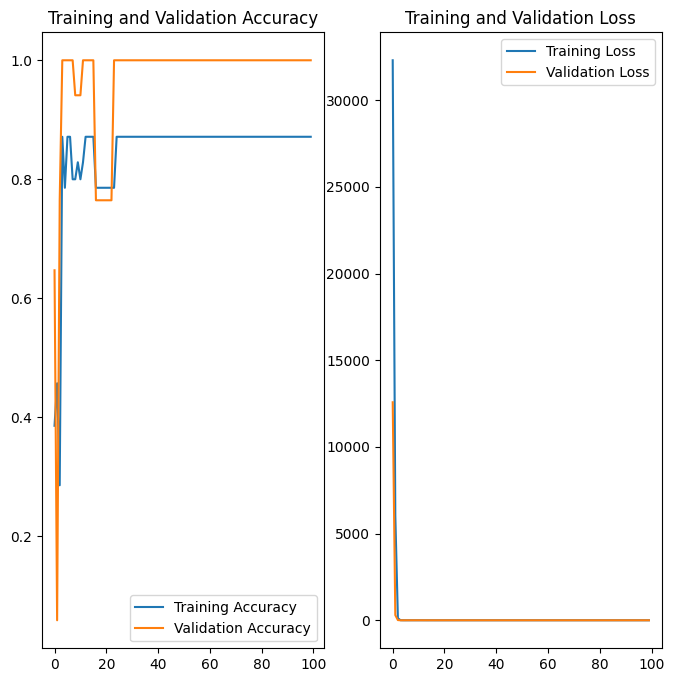

In [21]:
# Load model training stats
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot model accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot model loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Testing <a class="anchor"  id="sub13"></a>
We can now evaluate the model further. Due to lack of data, I ran testing on the same data as trained on, as well as the validation data. This provides a general overview of the model's preformance.


In [22]:
# Define stats for later
labels = []
predictions_made = []
nopandemic_correct = 0
prepandemic_correct = 0
peakpandemic_correct = 0

# Returns the index of the highest 
def highest_prediction(predictions):
    return pd.Series(predictions[0]).idxmax()

def num2word(num):
    print(num)
    if num == 0:
        return "nopandemic"
    elif num == 1:
        return "peakpandemic"
    elif num == 2:
        return "prepandemic"
    
print(f" -------------------------------------- NOPANDEMIC TESTING --------------------------------------\n")
for i in range(23):
    print(f" - IMAGE {i} -\n")
    img = tf.keras.utils.load_img(
        f"/kaggle/input/600x600pandemicplots/nopandemic/{i}.png", target_size=(img_height, img_width)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    labels.append(0)
    highest = highest_prediction(predictions)
    predictions_made.append(highest)
    print(f"Prediction: {num2word(highest)}")
    print(f"Actual: nopandemic")
    if highest == 0:
        print("##CORRECT##")
        nopandemic_correct += 1
    else:
        print("<<INCORRECT>>")
    print(f"{class_names[0]}:{round(predictions[0][0] * 100, 2)}% \n{class_names[1]}:{round(predictions[0][1] * 100, 2)}% \n{class_names[2]}:{round(predictions[0][2] * 100, 2)}%")
    
print(f" -------------------------------------- PREPANDEMIC TESTING --------------------------------------\n")
for i in range(18):
    print(f" - IMAGE {i} -\n")
    img = tf.keras.utils.load_img(
        f"/kaggle/input/600x600pandemicplots/prepandemic/{i}.png", target_size=(img_height, img_width)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    labels.append(2)
    highest = highest_prediction(predictions)
    predictions_made.append(highest)
    print(f"Prediction: {num2word(highest)}")
    print(f"Actual: prepandemic")
    if highest == 2:
        print("##CORRECT##")
        prepandemic_correct += 1
    else:
        print("<<INCORRECT>>")
    print(f"{class_names[0]}:{round(predictions[0][0] * 100, 2)}% \n{class_names[1]}:{round(predictions[0][1] * 100, 2)}% \n{class_names[2]}:{round(predictions[0][2] * 100, 2)}%")

print(f" -------------------------------------- PEAKPANDEMIC TESTING --------------------------------------\n")
for i in range(43):
    print(f" - IMAGE {i} -\n")
    img = tf.keras.utils.load_img(
        f"/kaggle/input/600x600pandemicplots/peakpandemic/{i}.png", target_size=(img_height, img_width)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    labels.append(1)
    highest = highest_prediction(predictions)
    predictions_made.append(highest)
    print(f"Prediction: {num2word(highest)}")
    print(f"Actual: peakpandemic")
    if highest == 1:
        print("##CORRECT##")
        peakpandemic_correct += 1
    else:
        print("<<INCORRECT>>")
    print(f"{class_names[0]}:{round(predictions[0][0] * 100, 2)}% \n{class_names[1]}:{round(predictions[0][1] * 100, 2)}% \n{class_names[2]}:{round(predictions[0][2] * 100, 2)}%")
    
print("-------------------------------------- FINAL RESULTS --------------------------------------")
print(f"\nnopandemic accuracy: {round(nopandemic_correct/23 * 100, 2)}%")
print(f"prepandemic accuracy: {round(prepandemic_correct/18 * 100, 2)}%")
print(f"peakpandemic accuracy: {round(peakpandemic_correct/43 * 100, 2)}%")

print(f"\n Final accuracy: {round((nopandemic_correct+prepandemic_correct+peakpandemic_correct)/87*100, 2)}%")
confusion_matrix = tf.math.confusion_matrix(labels, predictions_made)
#print("\nConfusion Matrix:")
#print(confusion_matrix)

 -------------------------------------- NOPANDEMIC TESTING --------------------------------------

 - IMAGE 0 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
0
Prediction: nopandemic
Actual: nopandemic
##CORRECT##
nopandemic:100.0% 
peakpandemic:0.0% 
prepandemic:0.0%
 - IMAGE 1 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0
Prediction: nopandemic
Actual: nopandemic
##CORRECT##
nopandemic:99.31% 
peakpandemic:0.08% 
prepandemic:0.61%
 - IMAGE 2 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0
Prediction: nopandemic
Actual: nopandemic
##CORRECT##
nopandemic:100.0% 
peakpandemic:0.0% 
prepandemic:0.0%
 - IMAGE 3 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0
Prediction: nopandemic
Actual: nopandemic
##CORRECT##
nopandemic:100.0% 
peakpandemic:0.0% 
prepandemic:0.0%
 - IMAGE 4 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2
Prediction: prepandemic
Actual: nopandemic
<<INCORRECT>>
nopandemic:34.46% 
peakpandemic:0.01% 
prepandemic:65.53%
 - IMAGE 5 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0
Prediction: nopandemic


### Plot Confusion Matrix <a class="anchor"  id="sub14"></a>

<Axes: >

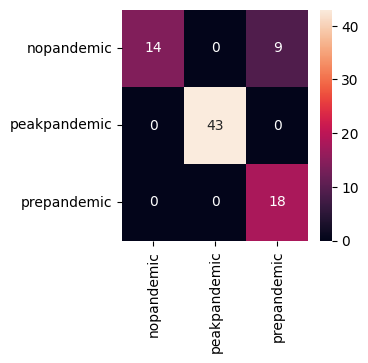

In [23]:
# Plot Confusion Matrix
df_confusion_matrix = pd.DataFrame(confusion_matrix.numpy().tolist(), index = ["nopandemic", "peakpandemic", "prepandemic"],
                                   columns = ["nopandemic", "peakpandemic", "prepandemic"])
plt.figure(figsize = (3,3))
sn.heatmap(df_confusion_matrix, annot=True)

FAQ